In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import RegularGridInterpolator
from pywt import wavedec2, waverec2, Wavelet
from scipy.optimize import minimize
plt.rcdefaults()
from scipy.stats import gaussian_kde
np.random.seed(2017) #Year of the Gödel Prize for Cynthia Dwork, Frank McSherry, Kobbi Nissim, and Adam D. Smith for the invention of (and the continuous work on) differential privacy

In [2]:
def create_grid(N, d=2, a=0, b=1):
    """Creates a grid in [a, b]^d with resolution N."""
    x = np.linspace(a, b, N)
    grid = np.meshgrid(*[x] * d, indexing='ij')
    return np.stack(grid, axis=-1), x

In [3]:
def wavelet_transform(f, wavelet_name='db4', level=None):
    """Performs wavelet decomposition."""
    wavelet = Wavelet(wavelet_name)
    coeffs = wavedec2(f, wavelet, level=level)
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet_name='db4'):
    """Performs inverse wavelet transform."""
    wavelet = Wavelet(wavelet_name)
    f_reconstructed = waverec2(coeffs, wavelet)
    return f_reconstructed

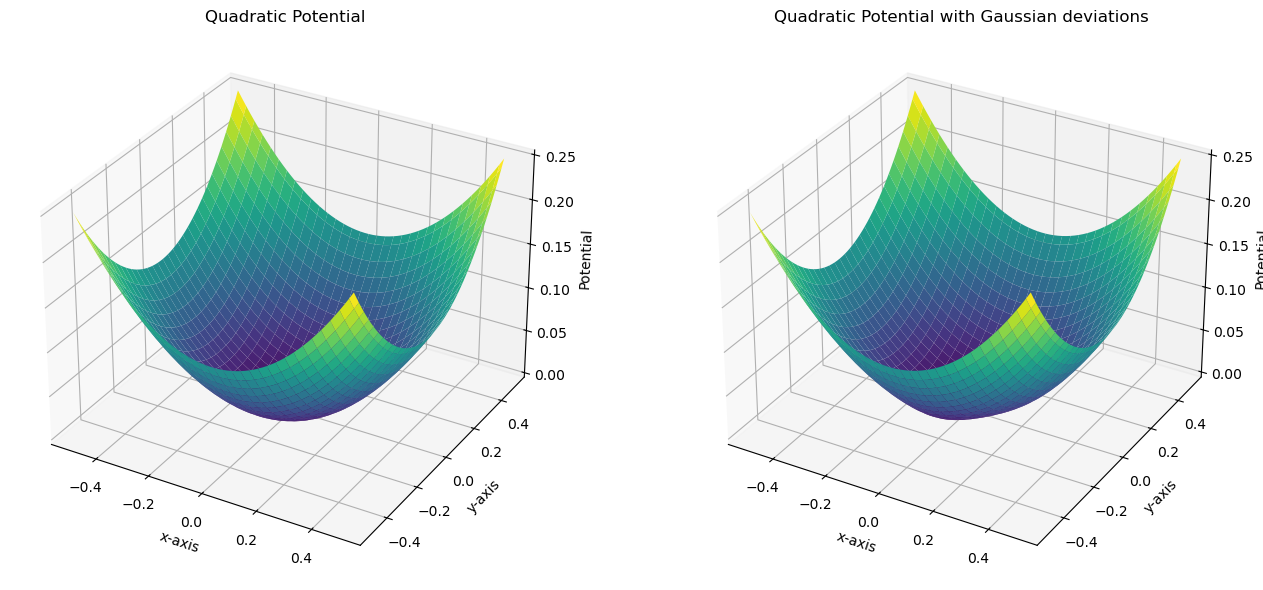

In [4]:
N = 64
a, b = -0.5, 0.5
a_extended, b_extended = a ,  b 


grid, x_values = create_grid(N, d=2, a=a_extended, b=b_extended)


f = 0.5 * (grid[..., 0]** 2 + grid[..., 1]** 2) #Quadratic potential

def gaussian_potential(sigma=1, mu=0, d=2):
    """Generates a Gaussian potential in d dimensions with given sigma and mu."""
    
    # Compute the squared distance from each point to the mean (mu)
    r_squared = np.sum((grid - mu)**2, axis=-1)  # Sum of squared distances in each dimension
    
    # Compute the Gaussian potential using the formula
    potential = np.exp(-r_squared / (2 * sigma**2))  # Gaussian potential
    
    return potential

# Perform wavelet transform
coeffs = wavelet_transform(f, wavelet_name='db4')

# Add noise to coefficients up to a fixed depth level
noise_level = 0.005
depth = 1
for i in range(1, min(len(coeffs), depth + 1)):
    coeffs[i] = tuple(c + noise_level * np.random.randn(*c.shape) for c in coeffs[i])

def get_noisy_potential():
    return f + 0.005 * gaussian_potential(sigma=0.1, mu=np.array([0.1 * np.random.randn(),0.1 * np.random.randn()]), d=2) - 0.005 * gaussian_potential(sigma=0.1, mu=np.array([0.1 * np.random.randn(),0.1 * np.random.randn()]), d=2) 

f_gaussian = get_noisy_potential() 


# Reconstruct the function from its noisy coefficients
f_modified = inverse_wavelet_transform(coeffs, wavelet_name='db4')

# Plot the original and modified functions as 3D plots
X, Y = np.meshgrid(np.linspace(a, b, N), np.linspace(a, b, N))

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, f, cmap="viridis")
ax1.set_title("Quadratic Potential")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
ax1.set_zlabel("Potential")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, f_gaussian, cmap="viridis")
ax2.set_title("Quadratic Potential with Gaussian deviations")
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_zlabel("Potential")

plt.tight_layout()
plt.show()

In [5]:
def compute_gradient(f, dx=1):
    df_dx = np.diff(f, axis=0)  # Difference along rows (x direction)
    df_dy = np.diff(f, axis=1)  # Difference along columns (y direction)

# Step 4: Adjust for the shape mismatch (since np.diff reduces the array size by 1 along each dimension)
# We need to pad the result to keep the same size as the original array
    df_dx = np.pad(df_dx, ((0, 1), (0, 0)), mode='edge')  # Pad the last row with the edge values
    df_dy = np.pad(df_dy, ((0, 0), (0, 1)), mode='edge')
    return df_dx/dx,df_dy/dx

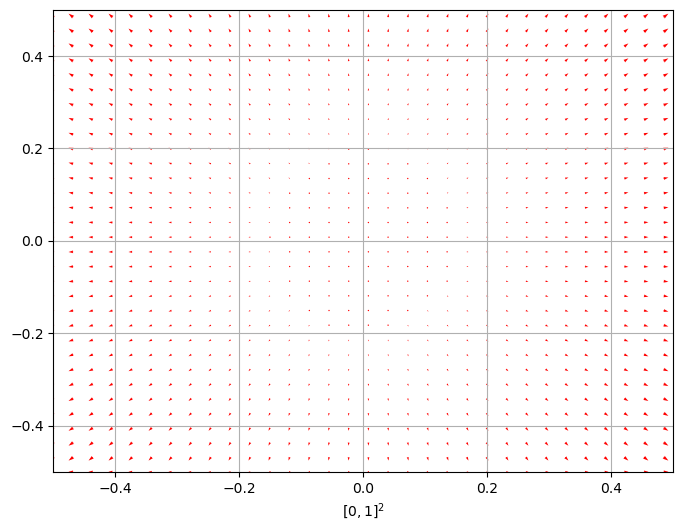

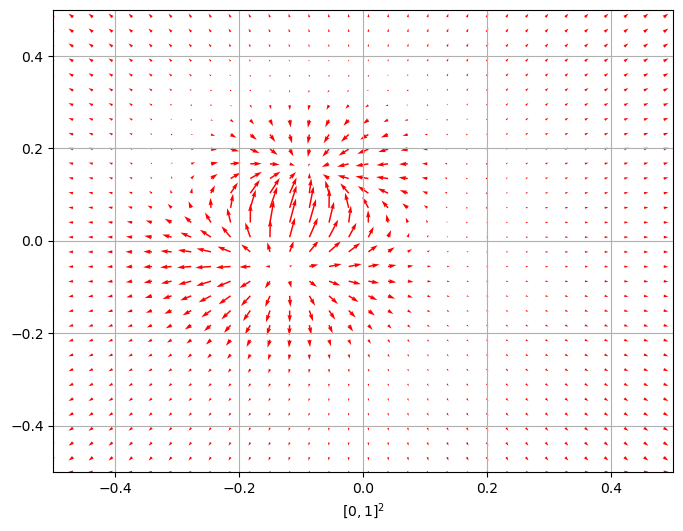

In [6]:
def plot_transform(f, title="", save_name=None):
    dx = (b - a) / N  # Discretization step
    grad_f = np.gradient(f, dx, dx)  # Compute the gradient with correct spacing

    n_subsample = 2  # Subsampling for visualization

    # Subsample the grid and gradient
    X = grid[..., 0][::n_subsample, ::n_subsample]
    Y = grid[..., 1][::n_subsample, ::n_subsample]
    U = grad_f[0][::n_subsample, ::n_subsample]  # Gradient in x-direction
    V = grad_f[1][::n_subsample, ::n_subsample]  # Gradient in y-direction

    # Plot the quiver plot showing arrows from (X, Y) to (U, V)
    plt.figure(figsize=(8, 6))
    plt.quiver(X, Y, U - X, V - Y, angles='xy', scale_units='xy', scale=1, color='r')  # Use grad_f as destination
    plt.title(title)
    plt.xlabel(r"$[-1/2, 1/2]^2$")
    #plt.ylabel("y-axis")
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.grid(True)
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

plot_transform(f)
plot_transform(f_gaussian)
#plot_transform(f_modified)

In [7]:
n_points=100000

dx = (b - a) / N
grad_potential = np.gradient(f_gaussian, dx, dx)
grad_f = np.gradient(f, dx, dx)

# Sample n points in [a, b]^2 uniformly
original_points = np.random.uniform(a, b, size=(n_points, 2))

# Clip points to the closest ones on the grid
def clip_to_grid(points, grid_range, grid_res):
    """Clips continuous points to the closest points on the grid."""
    clipped_indices = np.clip(
        np.round((points - grid_range[0]) / (grid_range[1] - grid_range[0]) * (grid_res - 1)),
        0,
        grid_res - 1
    ).astype(int)
    return clipped_indices

clipped_indices_original_points = clip_to_grid(original_points, (a, b), N)
clipped_original_points = np.zeros_like(original_points)
clipped_original_points[:, 0] = grid[..., 0][clipped_indices_original_points[:, 0], clipped_indices_original_points[:, 1]]
clipped_original_points[:, 1] = grid[..., 1][clipped_indices_original_points[:, 0], clipped_indices_original_points[:, 1]]

target_untransformed_points = np.random.uniform(a, b, size=(n_points, 2))

clipped_indices_target_untransformed = clip_to_grid(target_untransformed_points, (a, b), N)
clipped_target_untransformed_points = np.zeros_like(target_untransformed_points)
clipped_target_untransformed_points[:, 0] = grid[..., 0][clipped_indices_target_untransformed[:, 0], clipped_indices_target_untransformed[:, 1]]
clipped_target_untransformed_points[:, 1] = grid[..., 1][clipped_indices_target_untransformed[:, 0], clipped_indices_target_untransformed[:, 1]]

transformed_target_points = np.zeros_like(target_untransformed_points)
transformed_target_points[:, 0] = grad_potential[0][clipped_indices_target_untransformed[:, 0], clipped_indices_target_untransformed[:, 1]]
transformed_target_points[:, 1] = grad_potential[1][clipped_indices_target_untransformed[:, 0], clipped_indices_target_untransformed[:, 1]]

clipped_indices_transformed_target_points = clip_to_grid(transformed_target_points, (a, b), N)

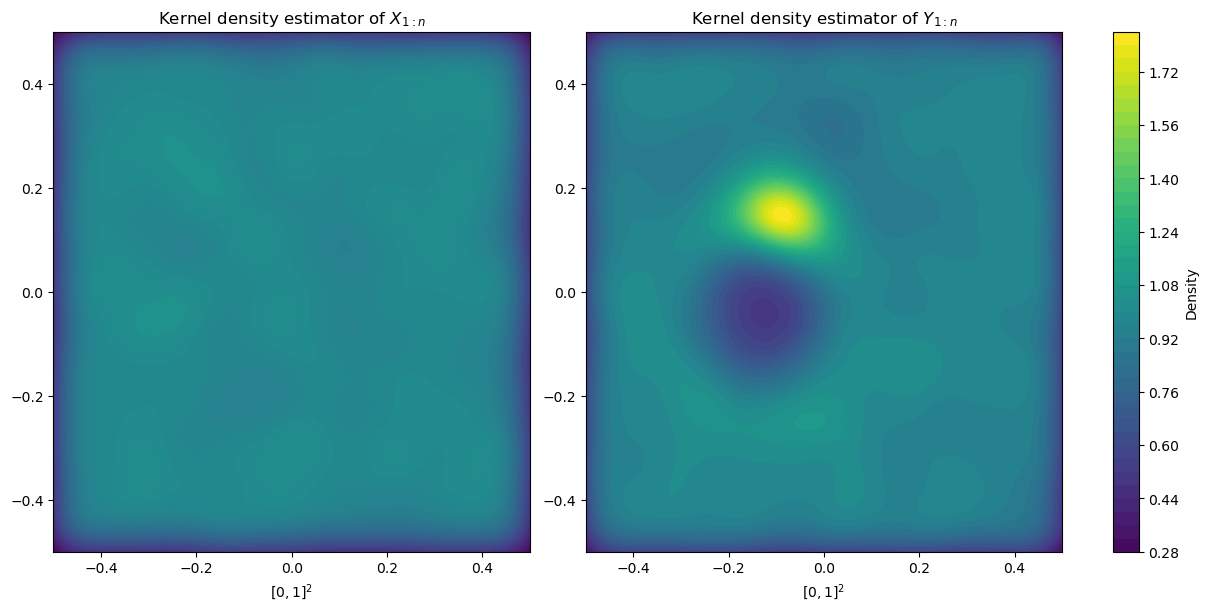

In [8]:
# Compute density using Gaussian KDE
def compute_density(points, xlim, ylim, grid_size=100):
    """Computes density using Gaussian KDE."""
    kde = gaussian_kde(points.T)
    x, y = np.linspace(xlim[0], xlim[1], grid_size), np.linspace(ylim[0], ylim[1], grid_size)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    density = kde(positions).reshape(X.shape)
    return X, Y, density

# Compute density for original and transformed points
X_orig, Y_orig, density_orig = compute_density(clipped_original_points, (a, b), (a, b))
X_trans, Y_trans, density_trans = compute_density(transformed_target_points, (a, b), (a, b))

# Determine the global min and max density values across both plots
vmin = min(density_orig.min(), density_trans.min())
vmax = max(density_orig.max(), density_trans.max())

# Plot densities with shared colorbar
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Plot first density
contour_orig = axs[0].contourf(X_orig, Y_orig, density_orig, levels=50, cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title(r"Kernel density estimator of $X_{1:n}$")
axs[0].set_xlabel(r"$[-1/2, 1/2]^2$")

# Plot second density
contour_trans = axs[1].contourf(X_trans, Y_trans, density_trans, levels=50, cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title(r"Kernel density estimator of $Y_{1:n}$")
axs[1].set_xlabel(r"$[-1/2, 1/2]^2$")

# Add a single shared colorbar
cbar = fig.colorbar(contour_trans, ax=axs, orientation="vertical", label="Density")

plt.savefig("X_and_Y_points.pdf")
plt.show()

In [9]:
def discrete_legendre_transform(f, x_grid, y_grid):
    """
    Computes the discrete Legendre transform of a function f.
    
    Parameters:
        f (numpy.ndarray): Function values defined on the grid, shape (N, N).
        x_grid (numpy.ndarray): Grid points in the domain, shape (N, N, 2).
        y_grid (numpy.ndarray): Grid points for the Legendre transform, shape (M, M, 2).
    
    Returns:
        numpy.ndarray: Discrete Legendre transform values, shape (M, M).
    """
    N = x_grid.shape[0]  # Size of x_grid
    M = y_grid.shape[0]  # Size of y_grid
    f_star = np.zeros((M, M))  # To store the Legendre transform

    # Iterate over all points in y_grid
    for i in range(M):
        for j in range(M):
            y = y_grid[i, j]  # A specific point in y_grid

            # Compute \langle x, y \rangle for all x on the grid
            dot_product = x_grid[..., 0] * y[0] + x_grid[..., 1] * y[1]

            # Compute the Legendre transform value at y
            f_star[i, j] = np.max(dot_product - f)
    
    return f_star

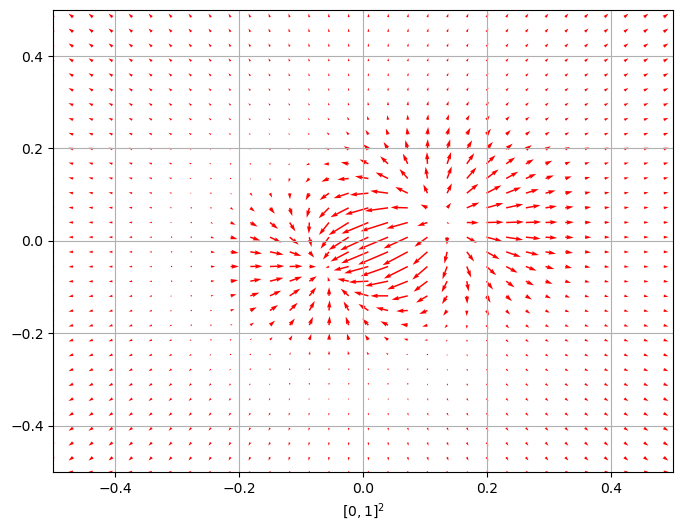

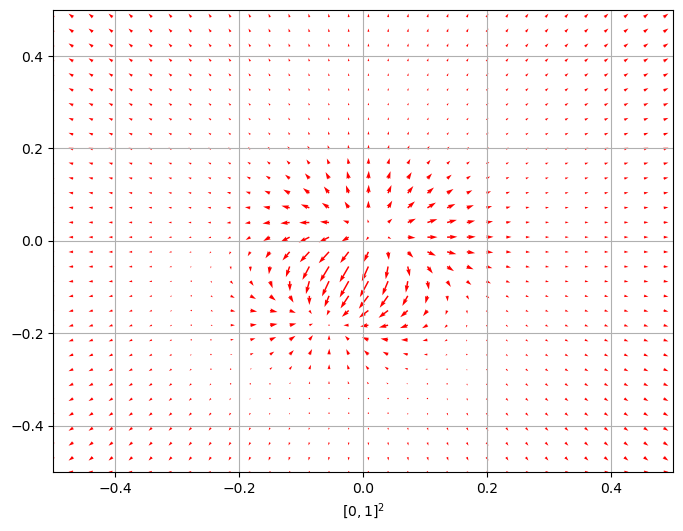

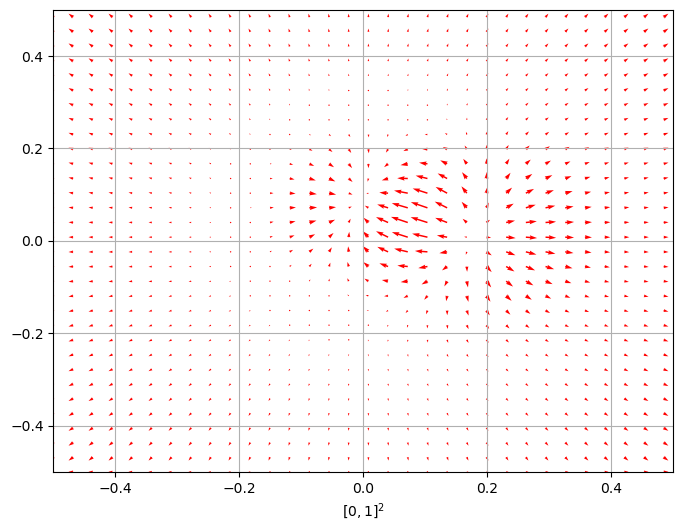

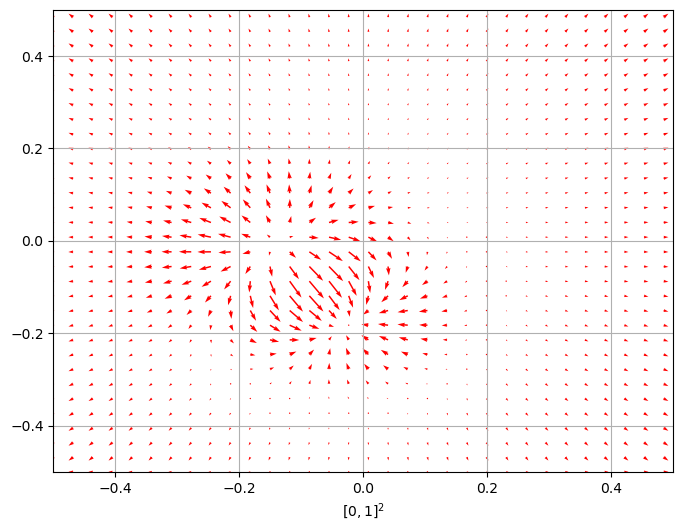

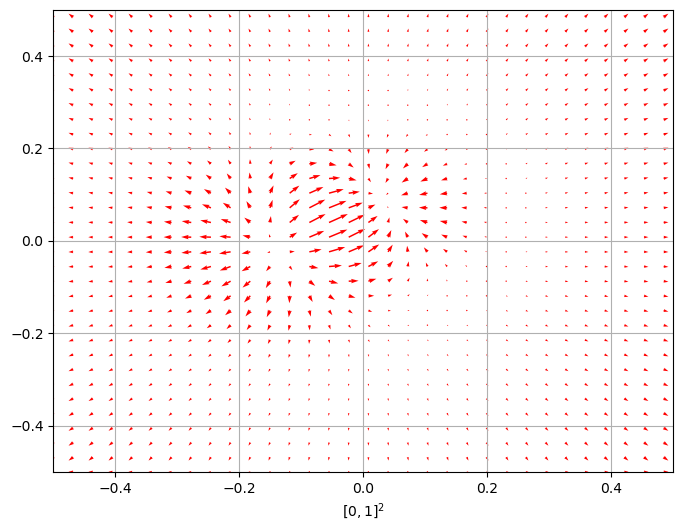

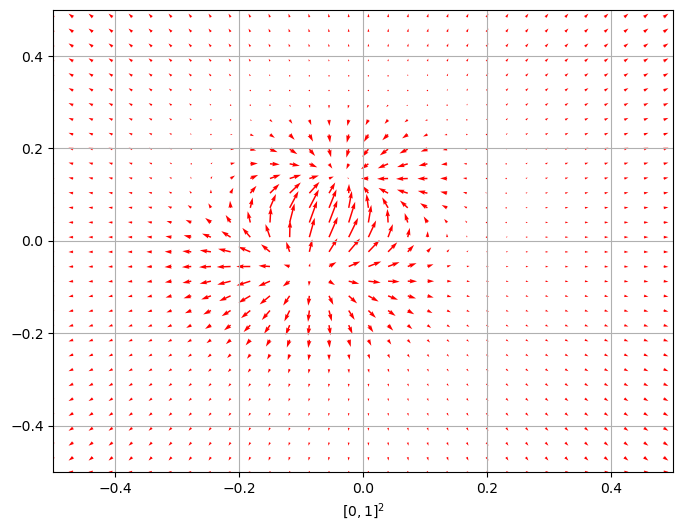

In [10]:
epsilon = 1.
C = 0.3

best_f = None
best_value = None

T = 2000


for i in range(T):
    #J = 8
    #noise_lvl_wavelets = 0.0002
    #coeffs = wavelet_transform(f, wavelet_name='db4')
    #for i in range(1, len(coeffs)):
    #    if i < J+1:
    #        coeffs[i] = tuple(c + noise_lvl_wavelets * np.random.randn(*c.shape) for c in coeffs[i])
    #    else :
    #        continue
    #        coeffs[i] = tuple(np.zeros(c.shape) for c in coeffs[i])

    #f_modified = inverse_wavelet_transform(coeffs, wavelet_name='db4')

    f_modified = get_noisy_potential()

    f_modified_data = np.clip(f_modified[clipped_indices_original_points[:, 0], clipped_indices_original_points[:, 1]],-C, C)
    f_modified_star = discrete_legendre_transform(f_modified, grid, grid)
    f_modified_star_data = np.clip(f_modified_star[clipped_indices_transformed_target_points[:, 0], clipped_indices_transformed_target_points[:, 1]], -C, C)
    #print(np.max(f_modified[clipped_indices_original_points[:, 0], clipped_indices_original_points[:, 1]]), np.max(f_modified_star[clipped_indices_transformed_target_points[:, 0], clipped_indices_transformed_target_points[:, 1]]))

    empirical_semi_dual_value = np.mean(f_modified_data) + np.mean(f_modified_star_data) + 2 * C / (n_points * epsilon) * np.random.laplace(1)

    if best_value is None or empirical_semi_dual_value < best_value:
        best_value = empirical_semi_dual_value
        best_f = f_modified
        plot_transform(best_f)

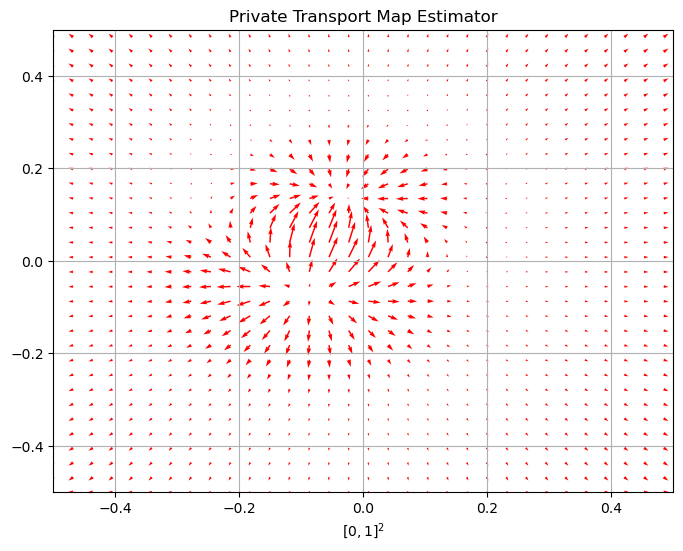

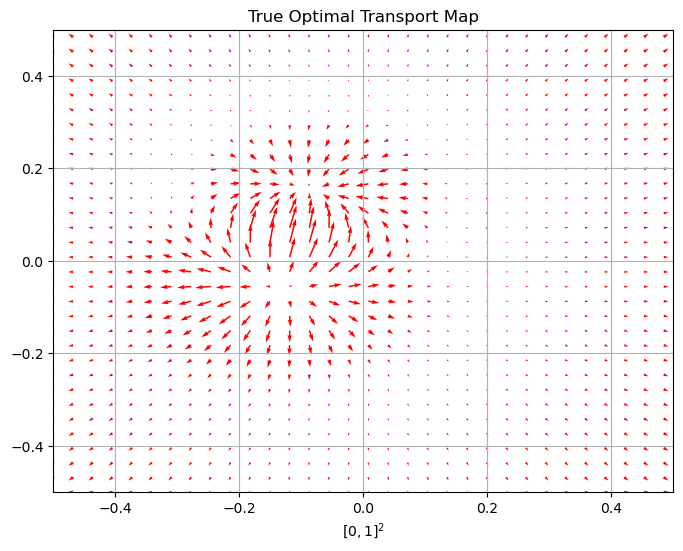

In [11]:
plot_transform(best_f, title="Private Transport Map Estimator", save_name="estimated_private_transport_map.pdf")
plot_transform(f_gaussian, title="True Optimal Transport Map", save_name="true_transport_map.pdf")